# Problema Inicial

O contexto do problema é um ambiente de atendimento, onde existem tickets e atendentes com diferentes capacidades e custos.
<b>Queremos encontrar a melhor forma de alocar os tickets com atendentes, minimizando o custo e o tempo de entrega.</b>

Sobre o problema:
  - Cada atendente tem um nome, uma senioridade(capacidade de entrega) e custo por hora
  - Cada ticket tem um nome, um valor de dificuldade(que será relacionado com a capacidade de entrega do atendente)
  - Neste caso, não vamos abordar 2 atendentes tratando o mesmo ticket

---
Dito isso podemos visualizar:
- Atendente:
    - Nome
    - Capacidade
    - R$/hora
    
- Ticket:
    - nome
    - Valor de dificuldade


### Cálculo do custo:

  - custo = "tempo gasto" x "R$/hora do atendente"
  - tempo gasto = "Valor de dificuldade do ticket" / "Capacidade do Atendente"
  - Valor de dificuldade do ticket = Dado inicial do Ticket
  - Capacidade do Atendente = Valor inicial do Atendente

### Cálculo do tempo:

Cálculo do tempo:
    - Somatório do "tempo gasto" de todos os atendentes
    
## Desafio com Algoritmo genético

Descobrir os valores de Hora Gasta e Custo distribuindo os tickets de forma otimizada.
Buscamos um equilíbrio entre Custo e Tempo, visando o melhor Custo Benefício

# Libs Para instalar

In [16]:
!pip install deap

In [17]:
!pip install numpy pandas matplotlib deap

# Importacao

In [18]:
import numpy as np
import pandas as pd
import random
import math
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import seaborn as sns

# Dados Iniciais

In [19]:
tarefas = [
    {"nome": "ticket_1", "peso": 4},
    {"nome": "ticket_2", "peso": 3},
    {"nome": "ticket_3", "peso": 4},
    {"nome": "ticket_4", "peso": 9},
    {"nome": "ticket_5", "peso": 5},
    {"nome": "ticket_6", "peso": 1},
    {"nome": "ticket_7", "peso": 2},
    {"nome": "ticket_8", "peso": 2},
    {"nome": "ticket_9", "peso": 5},
    {"nome": "ticket_10", "peso": 7}
]

profissionais = [
    {"nome": "Lucio", "capacidade": 1, "valor_hora": 100},
    {"nome": "Ana", "capacidade": 2, "valor_hora": 110},
    {"nome": "Gabriel", "capacidade": 3, "valor_hora": 120},
    {"nome": "Helena", "capacidade": 4, "valor_hora": 130},
    {"nome": "Igor", "capacidade": 5, "valor_hora": 140}
]

# Algoritimo Genético

## Preparação com toolbox e creator

In [20]:

creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))  # Minimizar custo e tempo
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Função para criar um indivíduo (uma solução de alocação)
def create_individual():
    # Para cada tarefa, escolhe aleatoriamente um profissional
    return [random.randint(0, len(profissionais) - 1) for _ in range(len(tarefas))]

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Função de avaliação - calcula custo e tempo da solução com ajustes para melhor refletir as regras
def evaluate(individual):
    # Inicializa o tempo para cada profissional
    tempo_total_profissional = [0] * len(profissionais)
    custo_total = 0

    # Para cada tarefa, calcular o tempo e custo
    for i, prof_idx in enumerate(individual):
        prof = profissionais[prof_idx]
        tarefa = tarefas[i]

        # Tempo necessário para resolver a tarefa (em horas)
        if prof["capacidade"] >= tarefa["peso"]:
            tempo = tarefa["peso"] / prof["capacidade"]
        else:
            # Penalização mais severa para profissionais com capacidade menor que o peso
            # da tarefa para garantir que a regra 3 seja respeitada
            tempo = tarefa["peso"] / prof["capacidade"] * 2.0

        # Arredonda para cima para a próxima hora completa (regra 1)
        horas_faturadas = math.ceil(tempo)

        # Atualiza o tempo total do profissional
        tempo_total_profissional[prof_idx] += tempo

        # Atualiza o custo total
        custo_total += horas_faturadas * prof["valor_hora"]

    # O tempo total de processamento é o máximo dos tempos de cada profissional
    tempo_processamento_total = max(tempo_total_profissional)

    # Adiciona penalização para balancear melhor as soluções entre custo e tempo
    # Isto ajuda a encontrar soluções variadas na fronteira de Pareto
    penalizacao_custo = custo_total * 0.01  # Pequena penalização proporcional ao custo
    penalizacao_tempo = tempo_processamento_total * 50  # Penalização proporcional ao tempo

    custo_ajustado = custo_total + penalizacao_tempo
    tempo_ajustado = tempo_processamento_total + penalizacao_custo

    return custo_ajustado, tempo_ajustado

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)  # Crossover de dois pontos
toolbox.register("mutate", tools.mutUniformInt, low=0, up=len(profissionais)-1, indpb=0.2)  # Mutação
toolbox.register("select", tools.selNSGA2)  # Seleção NSGA-II para otimização multi-objetivo

# Função para analisar a solução - versão melhorada
def analyze_solution(solution):
    alocacao = []
    tempo_total_profissional = [0] * len(profissionais)

    for i, prof_idx in enumerate(solution):
        prof = profissionais[prof_idx]
        tarefa = tarefas[i]

        # Calcula o tempo necessário
        if prof["capacidade"] >= tarefa["peso"]:
            tempo = tarefa["peso"] / prof["capacidade"]
        else:
            tempo = tarefa["peso"] / prof["capacidade"] * 1.5

        horas_faturadas = math.ceil(tempo)
        custo = horas_faturadas * prof["valor_hora"]

        tempo_total_profissional[prof_idx] += tempo

        alocacao.append({
            "tarefa": tarefa["nome"],
            "peso_tarefa": tarefa["peso"],
            "profissional": prof["nome"],
            "capacidade": prof["capacidade"],
            "tempo_estimado": round(tempo, 2),
            "horas_faturadas": horas_faturadas,
            "custo": custo
        })

    # Organiza os resultados
    df_alocacao = pd.DataFrame(alocacao)
    tempo_processo = max(tempo_total_profissional)
    custo_total = df_alocacao["custo"].sum()

    # Carga de trabalho por profissional
    carga_trabalho = []
    for i, tempo in enumerate(tempo_total_profissional):
        if tempo > 0:  # Só mostra profissionais com tarefas alocadas
            carga_trabalho.append({
                "profissional": profissionais[i]["nome"],
                "tempo_total": round(tempo, 2),
                "tarefas": len([x for x in solution if x == i])
            })

    df_carga = pd.DataFrame(carga_trabalho)

    return df_alocacao, df_carga, tempo_processo, custo_total

/opt/homebrew/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/opt/homebrew/lib/python3.10/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


## Execução Algorítimo Genético

### Sobre o Algoritmo genético

Análise Detalhada das Fases do Algoritmo Genético
Aqui está um resumo das fases do algoritmo genético que identifiquei e destaquei no código:
1. Definição do Problema

Linhas 8-36: Define os dados do problema (tarefas e profissionais)
O problema consiste em alocar tarefas a profissionais considerando suas capacidades, custos e a minimização de dois objetivos: custo total e tempo total.

2. Representação da Solução (Codificação)

Linhas 39-44: Define como cada solução é representada
Cada indivíduo é uma lista onde o índice representa a tarefa e o valor representa o profissional designado.

3. Inicialização da População

Linhas 49-54: Funções para criar indivíduos aleatoriamente
Linhas 141-143: Na função principal, inicializa a população com toolbox.population(n=tamanho_pop)

4. Função de Avaliação (Fitness)

Linhas 59-95: Implementa a função evaluate() que calcula o custo e tempo de cada solução
Linhas 156-160: Avaliação inicial da população
Linhas 199-204: Reavaliação dos indivíduos modificados em cada geração

5. Seleção

Linha 100: Registro do método de seleção NSGA-II (para otimização multi-objetivo)
Linhas 178-180: Aplicação da seleção na função principal

6. Cruzamento (Crossover)

Linha 105: Registro do operador de cruzamento (dois pontos)
Linhas 183-188: Aplicação do cruzamento com probabilidade definida

7. Mutação

Linha 110: Registro do operador de mutação (uniforme)
Linhas 193-198: Aplicação da mutação com probabilidade definida

8. Atualização da População

Linha 207: Substituição completa da população antiga pela nova

9. Critério de Parada

Linha 175: Loop for com número fixo de gerações (num_geracoes)

10. Elitismo

Linha 147: Criação do ParetoFront para manter soluções não-dominadas
Linhas 210-211: Atualização do hall of fame em cada geração

11. Pós-processamento

Linhas 229-243: Seleção das melhores soluções após a evolução completa
Identifica três soluções importantes: melhor equilíbrio, menor custo e menor tempo

12. Monitoramento da Evolução

Linhas 248-392: Funções de visualização para monitorar a evolução
Gera gráficos da frente de Pareto, evolução das métricas e análise visual das soluções

O algoritmo segue uma implementação completa de um algoritmo genético multi-objetivo, usando a biblioteca DEAP e aplicando o método NSGA-II para encontrar o conjunto de soluções ótimas balanceando custo e tempo.

In [21]:

# Versão atualizada da função principal para executar o algoritmo genético
def executar_algoritmo_genetico(tamanho_pop=1000, num_geracoes=100, prob_cruz=0.8, prob_mut=0.1):
    random.seed(42)  # Garantir reprodutibilidade

    # Inicializa a população
    pop = toolbox.population(n=tamanho_pop)
    hof = tools.ParetoFront()  # Armazena as soluções não-dominadas

    # Estatísticas para acompanhar a evolução
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min, axis=0)
    stats.register("avg", np.mean, axis=0)

    # Armazenar histórico para visualização
    historico_populacoes = []
    historico_fitness = []

    # Avalia a população inicial
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    historico_populacoes.append(pop[:])
    historico_fitness.append([ind.fitness.values for ind in pop])

    # Loop principal do algoritmo
    for g in range(num_geracoes):
        # Seleção dos indivíduos
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        # Crossover
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < prob_cruz:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        # Mutação
        for mutant in offspring:
            if random.random() < prob_mut:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Avaliação
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Atualização da população
        pop[:] = offspring

        # Atualiza o hall of fame
        hof.update(pop)

        # Armazenar para histórico
        historico_populacoes.append(pop[:])
        historico_fitness.append([ind.fitness.values for ind in pop])

        # Estatísticas da geração atual
        fits = [ind.fitness.values for ind in pop]
        min_fit = np.min(fits, axis=0)
        avg_fit = np.mean(fits, axis=0)

        # Exibe progresso
        print(f"-- Geração {g+1} --")
        print(f"  Min: {min_fit}")
        print(f"  Avg: {avg_fit}")

    # Seleciona as melhores soluções
    # 1. Melhor equilíbrio (70% custo, 30% tempo)
    pesos = (0.7, 0.3)
    indice_equilibrio = np.argmin([pesos[0]*ind.fitness.values[0] + pesos[1]*ind.fitness.values[1] for ind in pop])

    # 2. Menor custo
    indice_menor_custo = np.argmin([ind.fitness.values[0] for ind in pop])

    # 3. Menor tempo
    indice_menor_tempo = np.argmin([ind.fitness.values[1] for ind in pop])

    solucao_equilibrada = pop[indice_equilibrio]
    solucao_menor_custo = pop[indice_menor_custo]
    solucao_menor_tempo = pop[indice_menor_tempo]

    return solucao_equilibrada, solucao_menor_custo, solucao_menor_tempo, hof, historico_populacoes, historico_fitness


## Funções de visualizações

In [22]:
def visualizar_evolucao(historico_fitness):
    # Preparar dados
    geracoes = range(len(historico_fitness))
    melhor_custo = []
    media_custo = []
    melhor_tempo = []
    media_tempo = []

    for gen in historico_fitness:
        custos = [f[0] for f in gen]
        tempos = [f[1] for f in gen]

        melhor_custo.append(min(custos))
        media_custo.append(sum(custos) / len(custos))
        melhor_tempo.append(min(tempos))
        media_tempo.append(sum(tempos) / len(tempos))

    # Criar figura
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Gráfico de evolução do custo
    ax1.plot(geracoes, melhor_custo, 'r-', label='Melhor Custo')
    ax1.plot(geracoes, media_custo, 'r--', label='Média Custo')
    ax1.set_title('Evolução do Custo ao Longo das Gerações')
    ax1.set_xlabel('Geração')
    ax1.set_ylabel('Custo')
    ax1.legend()
    ax1.grid(True)

    # Gráfico de evolução do tempo
    ax2.plot(geracoes, melhor_tempo, 'b-', label='Melhor Tempo')
    ax2.plot(geracoes, media_tempo, 'b--', label='Média Tempo')
    ax2.set_title('Evolução do Tempo ao Longo das Gerações')
    ax2.set_xlabel('Geração')
    ax2.set_ylabel('Tempo')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Função para visualizar a frente de Pareto
def visualizar_pareto(populacao, fitness, hof):
    plt.figure(figsize=(10, 8))

    # Todos os indivíduos da população final
    custos = [f[0] for f in fitness]
    tempos = [f[1] for f in fitness]
    plt.scatter(custos, tempos, alpha=0.5, label='População Final')

    # Destacar a frente de Pareto
    pareto_custos = [ind.fitness.values[0] for ind in hof]
    pareto_tempos = [ind.fitness.values[1] for ind in hof]
    plt.scatter(pareto_custos, pareto_tempos, c='red', s=100, alpha=0.8, label='Frente de Pareto')

    # Conectar os pontos da frente de Pareto ordenados
    pareto_pontos = list(zip(pareto_custos, pareto_tempos))
    pareto_pontos.sort(key=lambda x: x[0])  # Ordenar por custo
    if pareto_pontos:
        pareto_x, pareto_y = zip(*pareto_pontos)
        plt.plot(pareto_x, pareto_y, 'r--')

    # Destacar as soluções extremas
    if pareto_custos:
        min_custo_idx = np.argmin(pareto_custos)
        min_tempo_idx = np.argmin(pareto_tempos)

        plt.scatter([pareto_custos[min_custo_idx]], [pareto_tempos[min_custo_idx]],
                  c='yellow', s=150, edgecolors='black', label='Menor Custo')
        plt.scatter([pareto_custos[min_tempo_idx]], [pareto_tempos[min_tempo_idx]],
                  c='green', s=150, edgecolors='black', label='Menor Tempo')

    plt.title('Frente de Pareto - Custo vs Tempo')
    plt.xlabel('Custo Total')
    plt.ylabel('Tempo Total')
    plt.grid(True)
    plt.legend()
    plt.show()

# Função para visualizar a melhor solução
def visualizar_solucao(solucao, title="Melhor Solução"):
    df_alocacao, df_carga, tempo, custo = analyze_solution(solucao)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Configurar cores para os profissionais
    prof_names = [prof["nome"] for prof in profissionais]
    colors = plt.cm.tab10(np.linspace(0, 1, len(prof_names)))
    prof_colors = {prof: color for prof, color in zip(prof_names, colors)}

    # Gráfico 1: Alocação de tarefas aos profissionais
    tarefas_nomes = [t["nome"] for t in tarefas]
    tarefas_pesos = [t["peso"] for t in tarefas]

    bars = ax1.bar(tarefas_nomes, tarefas_pesos)

    for i, bar in enumerate(bars):
        prof_name = df_alocacao.iloc[i]["profissional"]
        bar.set_color(prof_colors[prof_name])

    ax1.set_title('Alocação de Tarefas aos Profissionais')
    ax1.set_xlabel('Tarefas')
    ax1.set_ylabel('Peso da Tarefa')
    ax1.set_xticklabels(tarefas_nomes, rotation=45)

    # Adicionar legenda de cores
    handles = [plt.Rectangle((0,0),1,1, color=prof_colors[prof]) for prof in prof_names
              if prof in df_alocacao["profissional"].values]
    profs_legendas = [prof for prof in prof_names if prof in df_alocacao["profissional"].values]
    ax1.legend(handles, profs_legendas, title="Profissionais")

    # Gráfico 2: Tempo estimado vs Horas faturadas
    x = np.arange(len(df_alocacao))
    width = 0.35

    ax2.bar(x - width/2, df_alocacao["tempo_estimado"], width, label='Tempo Estimado')
    ax2.bar(x + width/2, df_alocacao["horas_faturadas"], width, label='Horas Faturadas')

    ax2.set_title('Tempo Estimado vs Horas Faturadas por Tarefa')
    ax2.set_xlabel('Tarefas')
    ax2.set_ylabel('Horas')
    ax2.set_xticks(x)
    ax2.set_xticklabels(df_alocacao["tarefa"], rotation=45)
    ax2.legend()

    # Gráfico 3: Carga de trabalho por profissional
    bars = ax3.bar(df_carga["profissional"], df_carga["tempo_total"])

    for i, bar in enumerate(bars):
        prof_name = df_carga.iloc[i]["profissional"]
        bar.set_color(prof_colors[prof_name])

    for i, row in df_carga.iterrows():
        ax3.text(i, row["tempo_total"] + 0.1, f"{row['tarefas']} tarefas",
                ha='center', va='bottom')

    ax3.axhline(y=tempo, color='r', linestyle='--', label=f'Tempo Total: {tempo:.2f}h')

    ax3.set_title('Tempo Total por Profissional')
    ax3.set_xlabel('Profissional')
    ax3.set_ylabel('Horas de Trabalho')
    ax3.legend()

    # Gráfico 4: Custo por tarefa
    bars = ax4.bar(df_alocacao["tarefa"], df_alocacao["custo"])

    for i, bar in enumerate(bars):
        prof_name = df_alocacao.iloc[i]["profissional"]
        bar.set_color(prof_colors[prof_name])

    ax4.set_title(f'Custo por Tarefa (Total: R$ {custo:.2f})')
    ax4.set_xlabel('Tarefas')
    ax4.set_ylabel('Custo (R$)')
    ax4.set_xticklabels(df_alocacao["tarefa"], rotation=45)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

    return df_alocacao, df_carga, tempo, custo


## Comparativo de Soluções

In [23]:
def comparar_solucoes(solucao1, solucao2, label1="Solução 1", label2="Solução 2"):
    print("Comparação de soluções:")

    # Analisar ambas as soluções
    df1, df_carga1, tempo1, custo1 = analyze_solution(solucao1)
    df2, df_carga2, tempo2, custo2 = analyze_solution(solucao2)

    print(f"\n{label1}: Tempo = {round(tempo1, 2)} horas, Custo = R$ {custo1}")
    print(f"{label2}: Tempo = {round(tempo2, 2)} horas, Custo = R$ {custo2}")

    print("\nDiferença:")
    print(f"Tempo: {round(tempo2 - tempo1, 2)} horas")
    print(f"Custo: R$ {custo2 - custo1}")

    # Visualizar comparação
    plt.figure(figsize=(10, 6))

    # Comparar custo
    plt.subplot(1, 2, 1)
    plt.bar([label1, label2], [custo1, custo2], color=['blue', 'green'])
    plt.title('Comparação de Custo')
    plt.ylabel('Custo (R$)')

    # Comparar tempo
    plt.subplot(1, 2, 2)
    plt.bar([label1, label2], [tempo1, tempo2], color=['blue', 'green'])
    plt.title('Comparação de Tempo')
    plt.ylabel('Tempo (horas)')

    plt.tight_layout()
    plt.show()

    return df1, df2, tempo1, tempo2, custo1, custo2

# Implementação

## Interações

In [31]:

# Executar o algoritmo
print("Executando algoritmo genético para alocação de tarefas...")
solucao_equilibrada, solucao_menor_custo, solucao_menor_tempo, hof, historico_populacoes, historico_fitness = executar_algoritmo_genetico(tamanho_pop=1000, num_geracoes=100)

Executando algoritmo genético para alocação de tarefas...
-- Geração 1 --
  Min: [2650.    29.4]
  Avg: [5190.20666667   61.81703333]
-- Geração 2 --
  Min: [2490.    28.2]
  Avg: [5206.9325    62.06195]
-- Geração 3 --
  Min: [2440.    27.5]
  Avg: [5225.69916667   62.36208333]
-- Geração 4 --
  Min: [2430.    27.3]
  Avg: [5236.75583333   62.58951667]
-- Geração 5 --
  Min: [2430.    27.3]
  Avg: [5269.20583333   63.10591667]
-- Geração 6 --
  Min: [2420.    27.2]
  Avg: [5288.02416667   63.43948333]
-- Geração 7 --
  Min: [2420.    27.2]
  Avg: [5303.6775    63.71175]
-- Geração 8 --
  Min: [2390.    26.9]
  Avg: [5311.98166667   63.85033333]
-- Geração 9 --
  Min: [2430.    27.6]
  Avg: [5306.09166667   63.80043333]
-- Geração 10 --
  Min: [2420.    27.4]
  Avg: [5321.76916667   64.08318333]
-- Geração 11 --
  Min: [2400.    27.2]
  Avg: [5339.16333333   64.34996667]
-- Geração 12 --
  Min: [2380.    26.8]
  Avg: [5331.23166667   64.20153333]
-- Geração 13 --
  Min: [2350.    26.3]

## Dados - Melhor solução

In [33]:

# Analisar a solução equilibrada
print("\nSolução com melhor equilíbrio entre custo e tempo:")
df_alocacao, df_carga, tempo, custo = analyze_solution(solucao_equilibrada)
print(f"Tempo total do processo: {tempo:.2f} horas")
print(f"Custo total: R$ {int(custo)}")



Solução com melhor equilíbrio entre custo e tempo:
Tempo total do processo: 4.90 horas
Custo total: R$ 1960


## Alocação - Melhor solução

In [34]:

print("\nAlocação de tarefas:")
print(df_alocacao.to_string(index=False))



Alocação de tarefas:
   tarefa  peso_tarefa profissional  capacidade  tempo_estimado  horas_faturadas  custo
 ticket_1            4         Igor           5            0.80                1    140
 ticket_2            3      Gabriel           3            1.00                1    120
 ticket_3            4       Helena           4            1.00                1    130
 ticket_4            9       Helena           4            3.38                4    520
 ticket_5            5         Igor           5            1.00                1    140
 ticket_6            1       Helena           4            0.25                1    130
 ticket_7            2          Ana           2            1.00                1    110
 ticket_8            2          Ana           2            1.00                1    110
 ticket_9            5         Igor           5            1.00                1    140
ticket_10            7         Igor           5            2.10                3    420


In [35]:

print("\nCarga de trabalho por profissional:")
print(df_carga.to_string(index=False))



Carga de trabalho por profissional:
profissional  tempo_total  tarefas
         Ana         2.00        2
     Gabriel         1.00        1
      Helena         4.62        3
        Igor         4.90        4


## Visualização do melhor tempo e melhor custo


Criando visualizações gráficas...


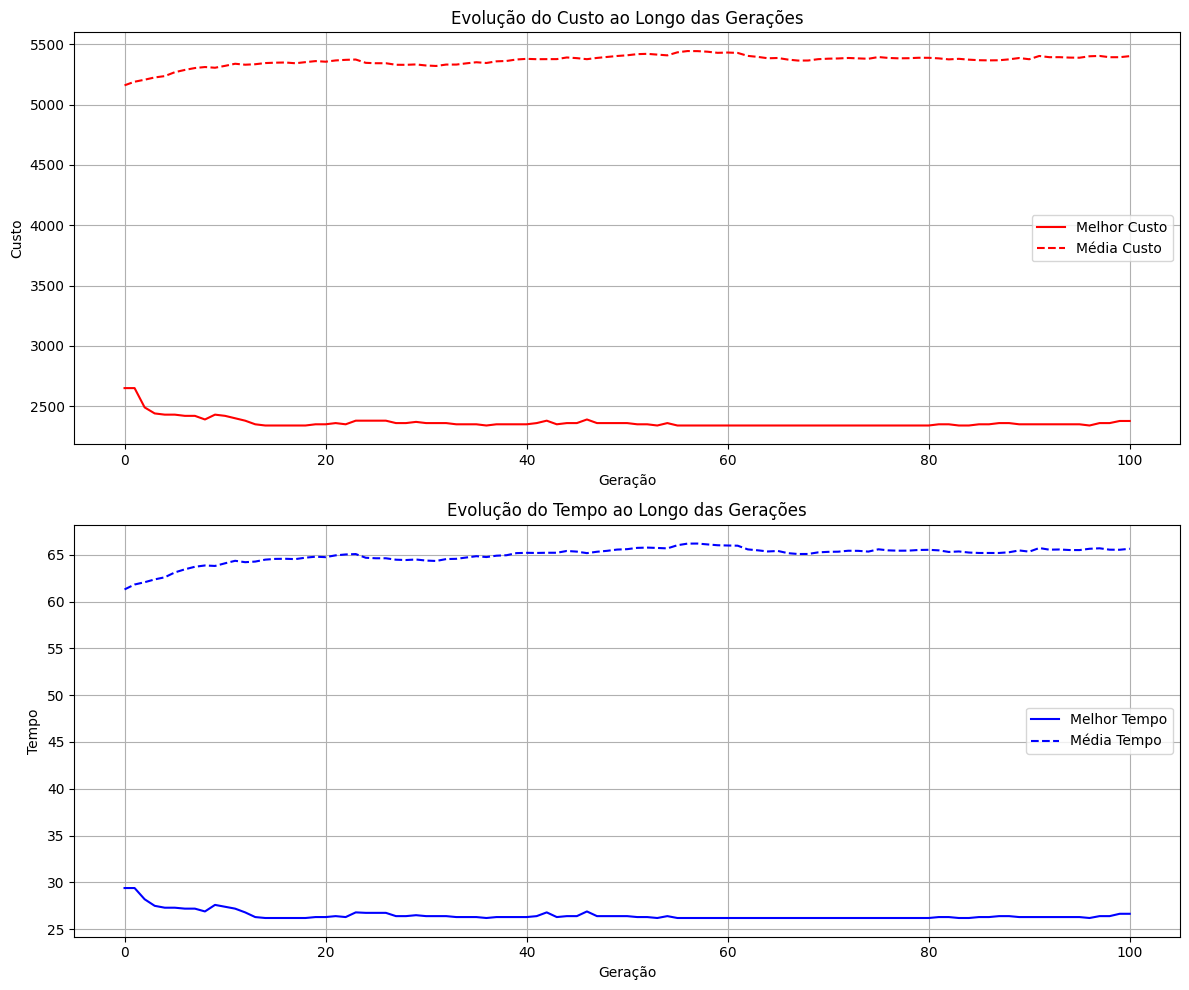

In [36]:

# Visualizações
print("\nCriando visualizações gráficas...")
visualizar_evolucao(historico_fitness)


## Visualização de Pareto

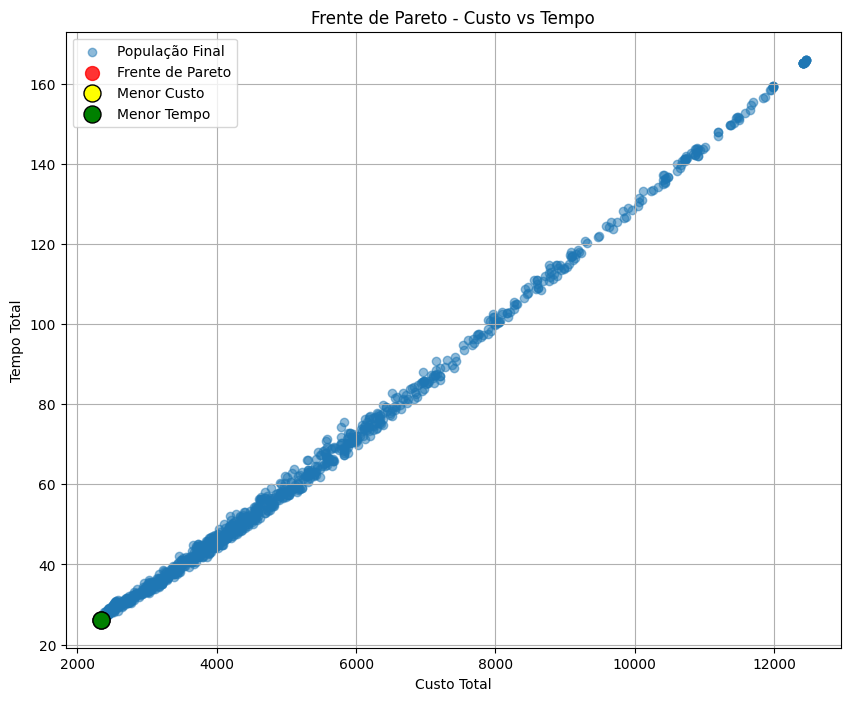

/var/folders/tb/zcff5wt13xv74tmy_vr90rg80000gn/T/ipykernel_35936/356306998.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(tarefas_nomes, rotation=45)
/var/folders/tb/zcff5wt13xv74tmy_vr90rg80000gn/T/ipykernel_35936/356306998.py:154: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(df_alocacao["tarefa"], rotation=45)


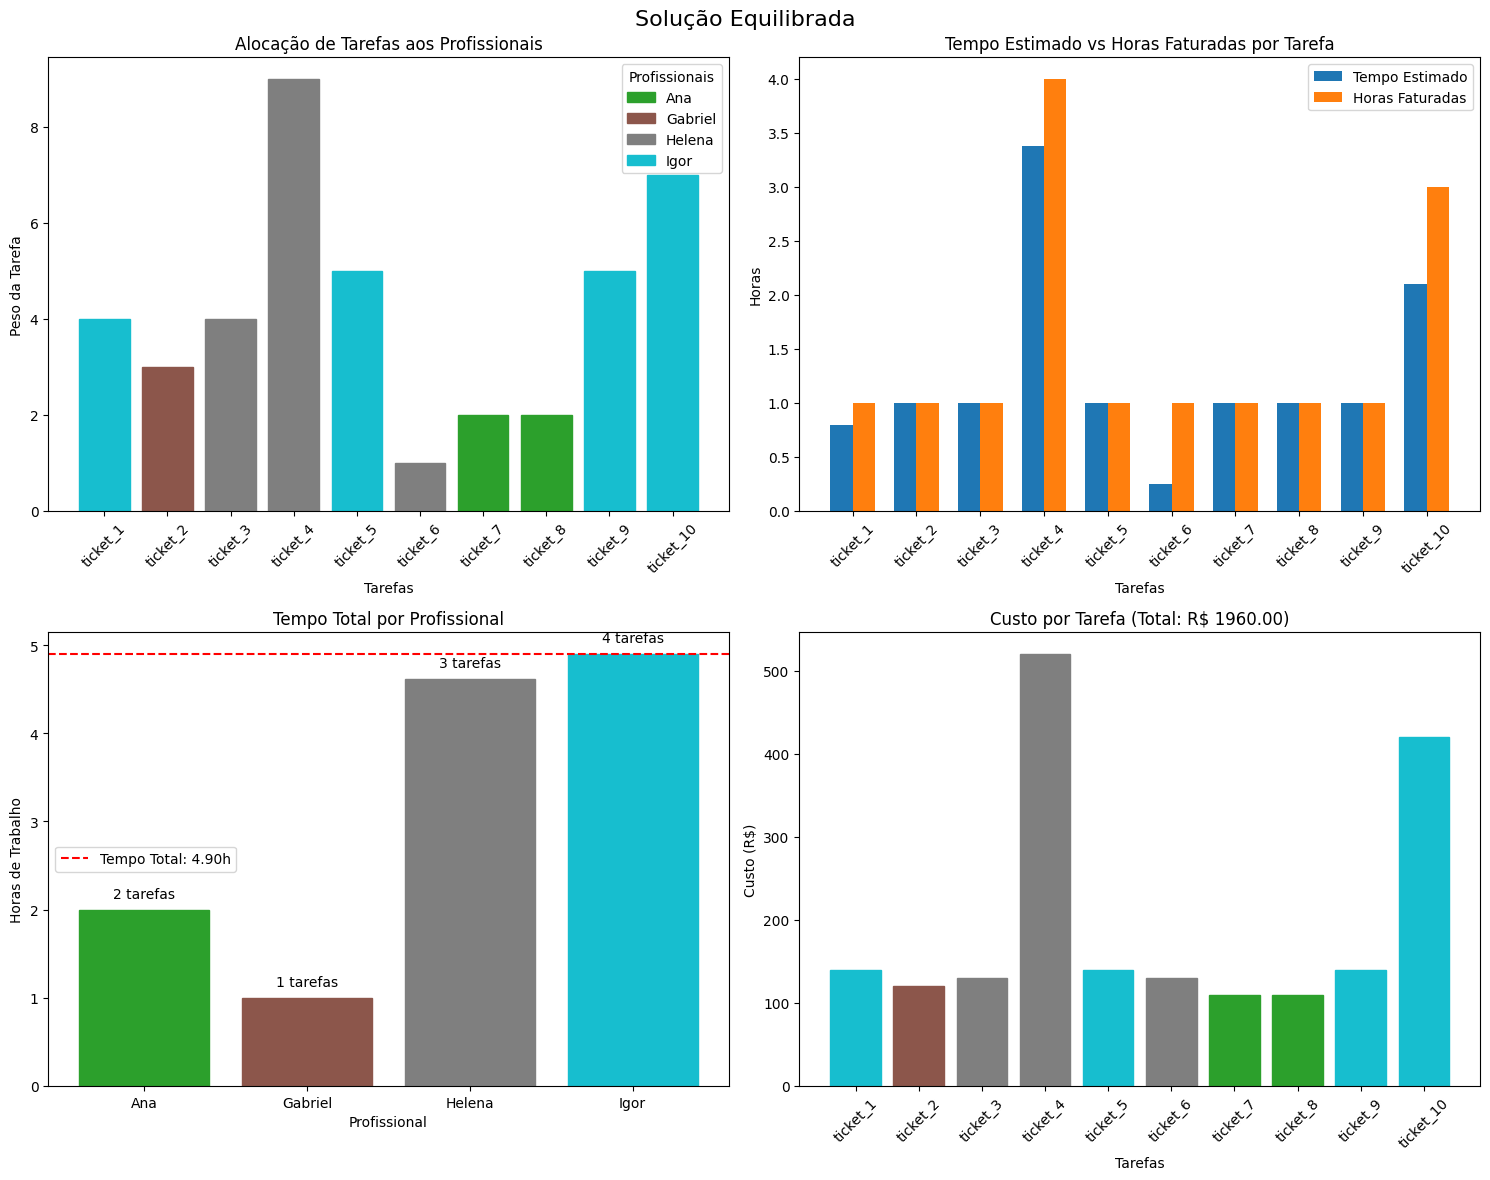

(      tarefa  peso_tarefa profissional  capacidade  tempo_estimado  \
 0   ticket_1            4         Igor           5            0.80   
 1   ticket_2            3      Gabriel           3            1.00   
 2   ticket_3            4       Helena           4            1.00   
 3   ticket_4            9       Helena           4            3.38   
 4   ticket_5            5         Igor           5            1.00   
 5   ticket_6            1       Helena           4            0.25   
 6   ticket_7            2          Ana           2            1.00   
 7   ticket_8            2          Ana           2            1.00   
 8   ticket_9            5         Igor           5            1.00   
 9  ticket_10            7         Igor           5            2.10   
 
    horas_faturadas  custo  
 0                1    140  
 1                1    120  
 2                1    130  
 3                4    520  
 4                1    140  
 5                1    130  
 6            

In [37]:
visualizar_pareto(historico_populacoes[-1], historico_fitness[-1], hof)
visualizar_solucao(solucao_equilibrada, "Solução Equilibrada")

## Comparativo das soluções


Comparando soluções extremas:
Comparação de soluções:

Menor Custo: Tempo = 4.9 horas, Custo = R$ 1960
Menor Tempo: Tempo = 4.9 horas, Custo = R$ 1960

Diferença:
Tempo: 0.0 horas
Custo: R$ 0


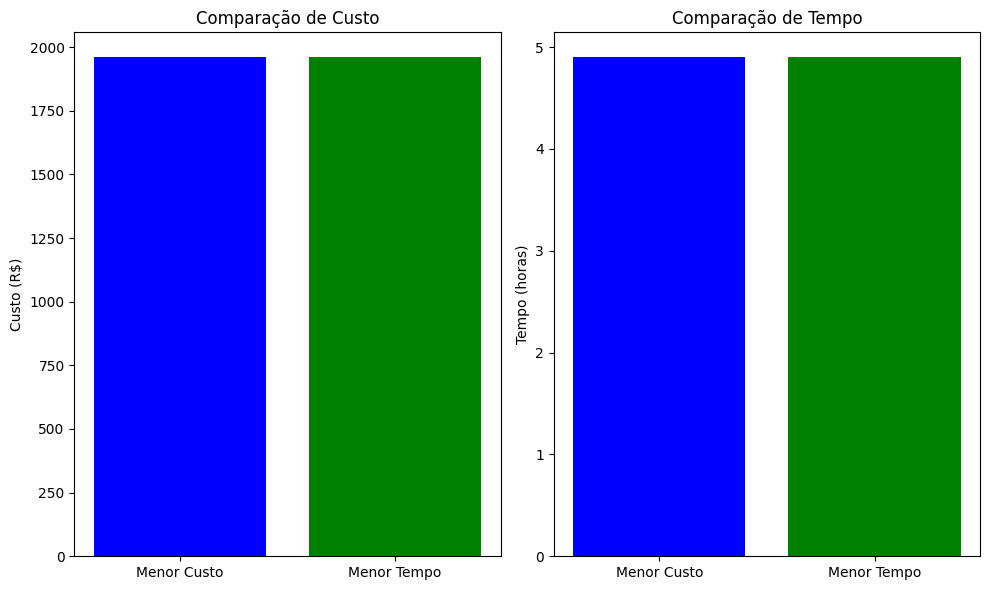

(      tarefa  peso_tarefa profissional  capacidade  tempo_estimado  \
 0   ticket_1            4         Igor           5            0.80   
 1   ticket_2            3      Gabriel           3            1.00   
 2   ticket_3            4       Helena           4            1.00   
 3   ticket_4            9       Helena           4            3.38   
 4   ticket_5            5         Igor           5            1.00   
 5   ticket_6            1       Helena           4            0.25   
 6   ticket_7            2          Ana           2            1.00   
 7   ticket_8            2          Ana           2            1.00   
 8   ticket_9            5         Igor           5            1.00   
 9  ticket_10            7         Igor           5            2.10   
 
    horas_faturadas  custo  
 0                1    140  
 1                1    120  
 2                1    130  
 3                4    520  
 4                1    140  
 5                1    130  
 6            

In [12]:
#  Comparar soluções extremas
print("\nComparando soluções extremas:")
comparar_solucoes(solucao_menor_custo, solucao_menor_tempo, "Menor Custo", "Menor Tempo")